# Final Project H-1B Model

## Preprocessing

In [1]:
import pandas as pd

df2019 = pd.read_pickle("./df2019.pkl")
df2018 = pd.read_pickle("./df2018.pkl")
df2017 = pd.read_pickle("./df2017.pkl")

In [2]:
year_mismatches = {'H1B_DEPENDENT': 'H-1B_DEPENDENT',
                       'EMPLOYMENT_START_DATE': 'PERIOD_OF_EMPLOYMENT_START_DATE',
                       'EMPLOYMENT_END_DATE': 'PERIOD_OF_EMPLOYMENT_END_DATE',
                       'WAGE_RATE_OF_PAY_FROM': 'WAGE_RATE_OF_PAY_FROM_1',
                       'TOTAL_WORKERS': 'TOTAL_WORKER_POSITIONS',
                       'NEW_CONCURRENT_EMP': 'NEW_CONCURRENT_EMPLOYMENT',
                       'PREVAILING_WAGE': 'PREVAILING_WAGE_1',
                       'PW_UNIT_OF_PAY': 'PW_UNIT_OF_PAY_1'
                  }

In [3]:
# Transform 2017 and 2018 data
keep_columns = ["CASE_STATUS", "CONTINUED_EMPLOYMENT", "SOC_CODE", "FULL_TIME_POSITION", "EMPLOYER_NAME", "PREVAILING_WAGE_1", "PW_UNIT_OF_PAY_1", "TOTAL_WORKER_POSITIONS", "WILLFUL_VIOLATOR", "H-1B_DEPENDENT"]

df2017 = df2017.rename(columns=year_mismatches)  # rename columns to match 2019 format
df2017 = df2017[(df2017["CASE_STATUS"] == "CERTIFIED") | (df2017["CASE_STATUS"] == "DENIED")]
df2017 = df2017[keep_columns]
df2017 = df2017.dropna()
df2017['Year'] = "2017"
df2017['PREVAILING_WAGE_1'] = df2017['PREVAILING_WAGE_1'].astype(str).str.replace(',', '').astype(float)
df2017['TOTAL_WORKER_POSITIONS'] = df2017['TOTAL_WORKER_POSITIONS'].astype(str).str.replace(',', '').astype(float)

df2018 = df2018.rename(columns=year_mismatches)  # rename columns to match 2019 format
df2018 = df2018[(df2018["CASE_STATUS"] == "CERTIFIED") | (df2018["CASE_STATUS"] == "DENIED")]
df2018 = df2018[keep_columns]
df2018 = df2018.dropna()
df2018['Year'] = "2018"
df2018['PREVAILING_WAGE_1'] = df2018['PREVAILING_WAGE_1'].astype(str).str.replace(',', '').astype(float)
df2018['TOTAL_WORKER_POSITIONS'] = df2018['TOTAL_WORKER_POSITIONS'].astype(str).str.replace(',', '').astype(float)

# Transform 2019 data

df2019 = df2019[(df2019["CASE_STATUS"] == "CERTIFIED") | (df2019["CASE_STATUS"] == "DENIED")]
df2019 = df2019[df2019['VISA_CLASS'] == 'H-1B']
df2019 = df2019[keep_columns]
df2019 = df2019.dropna()
df2019['Year'] = "2019"
df2019["PREVAILING_WAGE_1"] = pd.to_numeric(df2019["PREVAILING_WAGE_1"], errors='coerce').astype(float)
df2019["TOTAL_WORKER_POSITIONS"] = pd.to_numeric(df2019["TOTAL_WORKER_POSITIONS"], errors='coerce').astype(float)



In [4]:
print(df2018.head())
print(df2019.head())

  CASE_STATUS  CONTINUED_EMPLOYMENT SOC_CODE FULL_TIME_POSITION  \
0   CERTIFIED                     1  15-1132                  Y   
1   CERTIFIED                     0  13-2011                  Y   
2   CERTIFIED                     0  15-1141                  Y   
3   CERTIFIED                     0  15-1132                  Y   
4   CERTIFIED                     0  15-1132                  Y   

                 EMPLOYER_NAME  PREVAILING_WAGE_1 PW_UNIT_OF_PAY_1  \
0        MICROSOFT CORPORATION           112549.0             Year   
1       ERNST & YOUNG U.S. LLP            79976.0             Year   
2                 LOGIXHUB LLC            77792.0             Year   
3  HEXAWARE TECHNOLOGIES, INC.            84406.0             Year   
4             ECLOUD LABS,INC.            87714.0             Year   

   TOTAL_WORKER_POSITIONS WILLFUL_VIOLATOR H-1B_DEPENDENT  Year  
0                     1.0                N              N  2018  
1                     1.0                N  

In [5]:
import numpy as np
# create reference dictionaries for yearly acceptance rates by employer and submission volume by employer

employer_table_2017 = df2017[["EMPLOYER_NAME", "TOTAL_WORKER_POSITIONS"]].groupby(['EMPLOYER_NAME'], as_index=False).sum()
employer_table_2018 = df2018[["EMPLOYER_NAME", "TOTAL_WORKER_POSITIONS"]].groupby(['EMPLOYER_NAME'], as_index=False).sum()
employer_table_2019 = df2019[["EMPLOYER_NAME", "TOTAL_WORKER_POSITIONS"]].groupby(['EMPLOYER_NAME'], as_index=False).sum()

emp_app_count_dict = {}
emp_app_count_dict['2017'] = employer_table_2017.set_index('EMPLOYER_NAME').to_dict()["TOTAL_WORKER_POSITIONS"]
emp_app_count_dict['2018'] = employer_table_2018.set_index('EMPLOYER_NAME').to_dict()["TOTAL_WORKER_POSITIONS"]
emp_app_count_dict['2019'] = employer_table_2019.set_index('EMPLOYER_NAME').to_dict()["TOTAL_WORKER_POSITIONS"]

df2017['TOTAL_APP_COUNT'] = df2017.apply(lambda x: emp_app_count_dict['2017'][x["EMPLOYER_NAME"]], axis=1)
df2018['TOTAL_APP_COUNT'] = df2018.apply(lambda x: emp_app_count_dict['2018'][x["EMPLOYER_NAME"]], axis=1)
df2019['TOTAL_APP_COUNT'] = df2019.apply(lambda x: emp_app_count_dict['2019'][x["EMPLOYER_NAME"]], axis=1)

# now do acceptance rate, HAVE TO LAG BY 1 YEAR
df2017["CASE_STATUS_SUM_YEARLY"] = df2017.apply(lambda row: row["TOTAL_WORKER_POSITIONS"] if (row["CASE_STATUS"] == "CERTIFIED") else 0, axis=1)
df2018["CASE_STATUS_SUM_YEARLY"] = df2018.apply(lambda row: row["TOTAL_WORKER_POSITIONS"] if (row["CASE_STATUS"] == "CERTIFIED") else 0, axis=1)
df2019["CASE_STATUS_SUM_YEARLY"] = df2019.apply(lambda row: row["TOTAL_WORKER_POSITIONS"] if (row["CASE_STATUS"] == "CERTIFIED") else 0, axis=1)

#df2019["CASE_STATUS_SUM_YEARLY"] = df2019.apply(lambda row: row["TOTAL_WORKER_POSITIONS"] if (row["CASE_STATUS"] == "CERTIFIED") else 0, axis=1)
employer_table_2017 = df2017[["EMPLOYER_NAME", "TOTAL_WORKER_POSITIONS", "CASE_STATUS_SUM_YEARLY"]].groupby(['EMPLOYER_NAME'], as_index=False).sum()
employer_table_2018 = df2018[["EMPLOYER_NAME", "TOTAL_WORKER_POSITIONS", "CASE_STATUS_SUM_YEARLY"]].groupby(['EMPLOYER_NAME'], as_index=False).sum()
employer_table_2019 = df2019[["EMPLOYER_NAME", "TOTAL_WORKER_POSITIONS", "CASE_STATUS_SUM_YEARLY"]].groupby(['EMPLOYER_NAME'], as_index=False).sum()
# don't need 2019 data because lag by 1 year
#employer_table_2017 = df2019[["EMPLOYER_NAME", "TOTAL_WORKER_POSITIONS", "CASE_STATUS_SUM_YEARLY"]].groupby(['EMPLOYER_NAME'], as_index=False).sum()
employer_table_2017["ACCEPTANCE_RATE_YEARLY"] = employer_table_2017["CASE_STATUS_SUM_YEARLY"]/employer_table_2017["TOTAL_WORKER_POSITIONS"]
employer_table_2018["ACCEPTANCE_RATE_YEARLY"] = employer_table_2018["CASE_STATUS_SUM_YEARLY"]/employer_table_2018["TOTAL_WORKER_POSITIONS"]
employer_table_2019["ACCEPTANCE_RATE_YEARLY"] = employer_table_2019["CASE_STATUS_SUM_YEARLY"]/employer_table_2019["TOTAL_WORKER_POSITIONS"]

employer_table_2017 = employer_table_2017[["EMPLOYER_NAME", "ACCEPTANCE_RATE_YEARLY"]]
employer_table_2018 = employer_table_2018[["EMPLOYER_NAME", "ACCEPTANCE_RATE_YEARLY"]]
employer_table_2019 = employer_table_2019[["EMPLOYER_NAME", "ACCEPTANCE_RATE_YEARLY"]]

employer_table_2017 = employer_table_2017.set_index('EMPLOYER_NAME').to_dict()["ACCEPTANCE_RATE_YEARLY"]
employer_table_2018 = employer_table_2018.set_index('EMPLOYER_NAME').to_dict()["ACCEPTANCE_RATE_YEARLY"]
employer_table_2019 = employer_table_2019.set_index('EMPLOYER_NAME').to_dict()["ACCEPTANCE_RATE_YEARLY"]

employer_table_combined = {}
employer_table_combined['2017'] = employer_table_2017
employer_table_combined['2018'] = employer_table_2018
employer_table_combined['2019'] = employer_table_2019

# test new companies NaN instead of 0
df2019['ACCEPTANCE_RATE_LAGGED'] = df2019.apply(lambda x: employer_table_combined['2018'][x["EMPLOYER_NAME"]] if x["EMPLOYER_NAME"] in employer_table_combined['2018'] else 0, axis=1)
df2018['ACCEPTANCE_RATE_LAGGED'] = df2018.apply(lambda x: employer_table_combined['2017'][x["EMPLOYER_NAME"]] if x["EMPLOYER_NAME"] in employer_table_combined['2017'] else 0, axis=1)

# drop case_status_sum_yearly intermediary value
df2017 = df2017.drop(columns=["CASE_STATUS_SUM_YEARLY"])
df2018 = df2018.drop(columns=["CASE_STATUS_SUM_YEARLY"])
df2019 = df2019.drop(columns=["CASE_STATUS_SUM_YEARLY"])


In [6]:
df = pd.concat([df2019, df2018])
df = df[df["TOTAL_APP_COUNT"] > 1]

In [7]:
# fix SOC code excel bug
november_fixer = {'Nov-11': '11-2011',
                      'Nov-21': '11-3021',
                      'Nov-22': '11-2022',
                      'Nov-31': '11-3031',
                      'Nov-51': '11-3051',
                      'Nov-61': '11-3061',
                      'Nov-71': '11-3071',
                      'Nov-13': '11-3013',
                      'Nov-32': '11-2032',
                      'Nov-33': '11-9033',
                      'Nov-39': '11-9039',
                      'Nov-41': '11-9041',
                      'Nov-81': '11-9081',
                      'Nov-99': '11-9199'}
df['SOC_CODE'] = df['SOC_CODE'].replace(november_fixer)
#f.to_pickle("./combined_year_df")


In [8]:
# start with fresh variable

base_df = df
base_df.to_pickle("./base_df")
base_df.shape

(1091740, 13)

In [9]:
from imblearn.under_sampling import RandomUnderSampler

def undersampled(dataframe):
    df = dataframe.copy()
    rus = RandomUnderSampler(random_state=0)
    x, y = rus.fit_resample(df.drop(columns='CASE_STATUS'), df['CASE_STATUS'])
    x['CASE_STATUS'] = y
    return x

base_df = undersampled(base_df)
print(base_df.groupby('CASE_STATUS').count())

             CONTINUED_EMPLOYMENT  SOC_CODE  FULL_TIME_POSITION  \
CASE_STATUS                                                       
CERTIFIED                   12092     12092               12092   
DENIED                      12092     12092               12092   

             EMPLOYER_NAME  PREVAILING_WAGE_1  PW_UNIT_OF_PAY_1  \
CASE_STATUS                                                       
CERTIFIED            12092              12092             12092   
DENIED               12092              12092             12092   

             TOTAL_WORKER_POSITIONS  WILLFUL_VIOLATOR  H-1B_DEPENDENT   Year  \
CASE_STATUS                                                                    
CERTIFIED                     12092             12092           12092  12092   
DENIED                        12092             12092           12092  12092   

             TOTAL_APP_COUNT  ACCEPTANCE_RATE_LAGGED  
CASE_STATUS                                           
CERTIFIED              12092   

In [10]:
# take care of prevailing wage

wage_multiplier = {'Year': 1,
                    'Hour': 2080,
                    'Month': 12,
                    'Week': 52,
                    'Bi-Weekly': 26}

base_df['PREVAILING_WAGE_1'] = base_df.apply(lambda row: row["PREVAILING_WAGE_1"]*wage_multiplier[row["PW_UNIT_OF_PAY_1"]],axis=1)

# truncate SOC codes
base_df["SOC_CODE"] = base_df.apply(lambda row: row["SOC_CODE"][0:2],axis=1)

In [11]:
from sklearn.model_selection import train_test_split

dataset = base_df.drop(columns=["EMPLOYER_NAME", "PW_UNIT_OF_PAY_1"])
dataset = pd.get_dummies(dataset, columns=['Year', "SOC_CODE"]) # onehot encode

dataset['H-1B_DEPENDENT'].replace('Y', 1,inplace=True)
dataset['H-1B_DEPENDENT'].replace('N', 0,inplace=True)

dataset['WILLFUL_VIOLATOR'].replace('Y', 1,inplace=True)
dataset['WILLFUL_VIOLATOR'].replace('N', 0,inplace=True)

#dataset['AGENT_REPRESENTING_EMPLOYER'].replace('Y', 1,inplace=True)

dataset['CONTINUED_EMPLOYMENT'].replace('B', 0,inplace=True)

dataset['FULL_TIME_POSITION'].replace('Y', 1,inplace=True)
dataset['FULL_TIME_POSITION'].replace('N', 0,inplace=True)
dataset['CASE_STATUS'].replace('CERTIFIED', 1,inplace=True)
dataset['CASE_STATUS'].replace('DENIED', 0,inplace=True)


## Modeling

In [66]:
## from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import KFold

from tabulate import tabulate
import datetime
import copy
import warnings
warnings.filterwarnings('ignore')


# Dictionaries of models and hyperparameters
MODELS = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'LogisticRegression': LogisticRegression(), 
    'LinearSVC': LinearSVC(),
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
}

GRID = {
    'DecisionTreeClassifier': [{'criterion': 'gini'}],
    'LogisticRegression': [{'penalty': x, 'C': y, 'random_state': 0} 
                           for x in ('l2', 'none') \
                           for y in (0.01, 0.1, 1, 10, 100)],
    'GaussianNB': [{'priors': None}],
    'AdaBoostClassifier': [{'learning_rate': x, 'n_estimators': y} for x in [0.1,0.5] for y in [10,100,1000]],
    'LinearSVC': [{'C': x, 'random_state': 0} for x in (0.01, 0.1, 1, 10, 100)],
    'SVC': [{'C': x, 'random_state': 0} for x in (0.01, 0.1, 1, 10, 100)],
    'GradientBoostingClassifier': [{'loss': a, 'n_estimators': x} for a in ['deviance', 'exponential'] for x in [100, 1000]],
    'RandomForestClassifier': [{'criterion': a, 'n_estimators': x, 'max_depth': y, 'n_jobs': -1} for a in ['gini', 'entropy'] for x in [100, 1000] for y in [10,100]]
}

results = []
sc = StandardScaler()
continuous_cols = ["PREVAILING_WAGE_1", "TOTAL_WORKER_POSITIONS", "TOTAL_APP_COUNT", "ACCEPTANCE_RATE_LAGGED"]

fold_count = 5
kfold = KFold(fold_count, True, 0) # 5 folds, randomize before, set random seed = 0
folds = kfold.split(dataset)
# train-test loop
for train_idx, test_idx in folds:
    print(" ==> Training new split ")
    
    # split into features and labels
    train = dataset.iloc[train_idx]
    test = dataset.iloc[test_idx]
    test_targets = test["CASE_STATUS"]
    test_features = test.drop(["CASE_STATUS"], axis=1)
    train_targets = train["CASE_STATUS"]
    train_features = train.drop(["CASE_STATUS"], axis=1)
    
    # scaler, normalize on train first then test
    for col in continuous_cols:
        train_features[col] = sc.fit_transform(train_features[col].values.reshape(-1,1))
        test_features[col] = sc.transform(test_features[col].values.reshape(-1,1))

    # Loop over models 
    for model_key in MODELS.keys():
        print("Training model:" + str(model_key))

        # Loop over parameters 
        for params in GRID[model_key]: 

            # Create model 
            model = MODELS[model_key]
            model.set_params(**params)

            # Fit model on training set 
            model.fit(train_features, train_targets)

            # Predict on testing set 
            test_predictions = model.predict(test_features)

            # Evaluate predictions 
            acc = accuracy_score(test_targets, test_predictions)
            recall =recall_score(test_targets, test_predictions)
            prec = precision_score(test_targets, test_predictions)
            f1 = f1_score(test_targets, test_predictions)
            roc_auc = roc_auc_score(test_targets, test_predictions)

            # Store results in your results data frame
            #results.append((model.get_params(), accuracy))
            curr_model = copy.deepcopy(model) 
            results.append((curr_model, recall, prec, f1, roc_auc))


results = pd.DataFrame(results, columns=["Model","Recall", "Prec", "F1","ROC-AUC"])
results["Model"] = results.apply(lambda x: str(x["Model"]), axis=1)
results = results.groupby('Model').mean()
display(results)

 ==> Training new split 
Training model:DecisionTreeClassifier
Training model:LogisticRegression
Training model:LinearSVC
Training model:SVC
Training model:GaussianNB
Training model:AdaBoostClassifier
Training model:GradientBoostingClassifier
Training model:RandomForestClassifier
 ==> Training new split 
Training model:DecisionTreeClassifier
Training model:LogisticRegression
Training model:LinearSVC
Training model:SVC
Training model:GaussianNB
Training model:AdaBoostClassifier
Training model:GradientBoostingClassifier
Training model:RandomForestClassifier
 ==> Training new split 
Training model:DecisionTreeClassifier
Training model:LogisticRegression
Training model:LinearSVC
Training model:SVC
Training model:GaussianNB
Training model:AdaBoostClassifier
Training model:GradientBoostingClassifier
Training model:RandomForestClassifier
 ==> Training new split 
Training model:DecisionTreeClassifier
Training model:LogisticRegression
Training model:LinearSVC
Training model:SVC
Training model:G

,Recall,Prec,F1,ROC-AUC
Model,,,,
"AdaBoostClassifier(learning_rate=0.1, n_estimators=10)",0.772179,0.637761,0.698490,0.666790
"AdaBoostClassifier(learning_rate=0.1, n_estimators=100)",0.751115,0.676424,0.711726,0.695815
"AdaBoostClassifier(learning_rate=0.1, n_estimators=1000)",0.749297,0.683166,0.714658,0.700843
"AdaBoostClassifier(learning_rate=0.5, n_estimators=10)",0.752551,0.663017,0.704845,0.684898
"AdaBoostClassifier(learning_rate=0.5, n_estimators=100)",0.748376,0.681324,0.713251,0.699151
"AdaBoostClassifier(learning_rate=0.5, n_estimators=1000)",0.748311,0.685124,0.715292,0.702185
DecisionTreeClassifier(),0.660260,0.682603,0.671214,0.676633
GaussianNB(),0.990238,0.515529,0.678045,0.529821
GradientBoostingClassifier(),0.770948,0.687311,0.726674,0.710079


Text(0.5, 1.0, '2-class Precision-Recall curve')

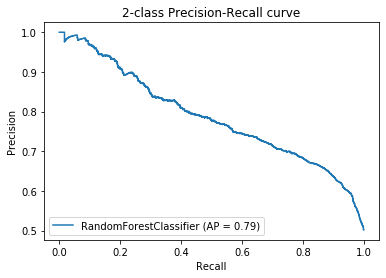

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

train, test = train_test_split(dataset, test_size=0.2, random_state=0)
test_targets = test["CASE_STATUS"]
test_features = test.drop(["CASE_STATUS"], axis=1)
train_targets = train["CASE_STATUS"]
train_features = train.drop(["CASE_STATUS"], axis=1)

clf = RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1)
clf.fit(train_features, train_targets)
disp = plot_precision_recall_curve(clf, test_features, test_targets)
disp.ax_.set_title('2-class Precision-Recall curve')

['ACCEPTANCE_RATE_LAGGED', 'TOTAL_APP_COUNT', 'PREVAILING_WAGE_1', 'H-1B_DEPENDENT', 'SOC_CODE_15', 'TOTAL_WORKER_POSITIONS', 'CONTINUED_EMPLOYMENT', 'Year_2019', 'Year_2018', 'FULL_TIME_POSITION', 'SOC_CODE_29', 'SOC_CODE_13', 'SOC_CODE_11', 'SOC_CODE_17', 'SOC_CODE_23', 'SOC_CODE_19', 'SOC_CODE_25', 'SOC_CODE_27', 'SOC_CODE_41', 'SOC_CODE_21', 'SOC_CODE_43', 'SOC_CODE_39', 'WILLFUL_VIOLATOR', 'SOC_CODE_35', 'SOC_CODE_49', 'SOC_CODE_47', 'SOC_CODE_37', 'SOC_CODE_51', 'SOC_CODE_33', 'SOC_CODE_53', 'SOC_CODE_45', 'SOC_CODE_31']


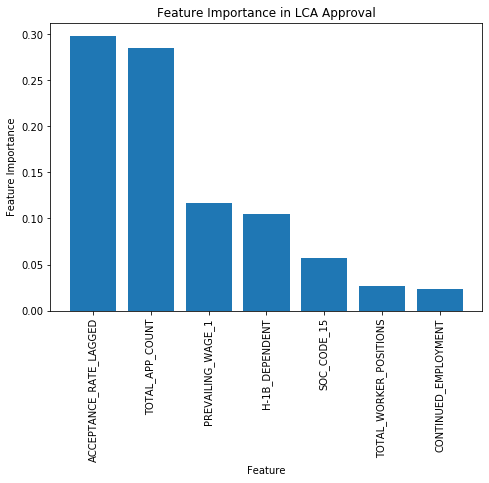

In [64]:
#forest_dt = RandomForestClassifier(criterion="gini", max_depth=5, min_samples_split=10, n_estimators=5000)
#model = forest_dt.fit(train_features,train_target)
import matplotlib.pyplot as plt
    
# plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = test_features.columns.values
importances = clf.feature_importances_
features = [x for _, x in sorted(zip(importances,features), key=lambda pair: pair[0])]
features.reverse()
print(features)
importances = list(importances)
importances.sort(reverse=True)

ax.bar(features[0:7],importances[0:7])
ax.set_title("Feature Importance in LCA Approval")
ax.set_xlabel("Feature")
ax.set_ylabel("Feature Importance")
plt.xticks(rotation=90)
plt.show()

In [65]:
dataset.to_pickle("./v2_dataset.pkl")